## Model

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admissible combinations of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Poisson(\lambda_h)$.
* The mean $\lambda_h$ depends on the (latent) features of nodes in $h$: $$\lambda_h=\sum_k\prod_{i\in h}r_i\theta_{ik},$$ where $\theta_{ik}$ is the percentage of node $i$ in block $k$  ($\sum_{k}\theta_{ik}=1$), and $r_i$ corresponds to the popularity of node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$ and $r=(r_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Estimation: 
    * $H$ is too big (all possible combinations of nodes). Therefore, use stochastic gradient descent to estimate $\theta$ and $r$
    * Let $\theta_{ij}=\theta_{ij}r_i$, so that we only need to deal with one set of variables $\theta$.
    * Also, because $E$ (hyperedges) is much smaller than $H$, we use negative sampling in picking the hyperedges and non-hyperedges in stochastic gradient descent.

## Workbench

In [1]:
import time
import sys
import pandas as pd
import scipy.sparse as ssp
import numpy as np
from functools import partial
from multiprocessing import Pool, cpu_count
from scipy.stats import dirichlet
from collections import Counter
from datetime import datetime
import random
from collections import defaultdict
from scipy.optimize import minimize
import pickle as pickle
from scipy.stats import pearsonr

In [2]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg),
        self.start_time=time.time()
        sys.stdout.flush()
    def stop(self,msg=''):
        if msg:
            print("{}: {} seconds".format(msg,time.time()-self.start_time))
        else:
            print("Elapsed time: {} seconds".format(time.time()-self.start_time))
        sys.stdout.flush()
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Load Data

In [3]:
tic.go('Reading data...')
df=pd.read_csv('/home/bill10/Datasets/Medline/full.txt', sep=' ', header=None, usecols=[0,1], names=['paper','mesh'])
df['paper']=df['paper']-df['paper'].min()
df['mesh']=df['mesh']-df['mesh'].min()
tic.stop()

Reading data...
Elapsed time: 65.98396682739258 seconds


In [4]:
tic.go()
G=ssp.coo_matrix((np.ones(len(df['paper']),dtype=np.int8),(df['paper'],df['mesh'])),shape=(df['paper'].max()+1, df['mesh'].max()+1),dtype=np.int8).tocsr()
tic.stop()

Elapsed time: 12.47361969947815 seconds


In [5]:
del df

In [6]:
id2mesh=pd.read_csv('/home/bill10/Datasets/Medline/id_to_name.txt',sep='\t',header=None,names=['id','name'])
id2mesh=id2mesh['name'].values

## Inference

In [8]:
def ph(h,theta):
    # Propensity of a group of nodes (h)
    return theta[list(h),:].prod(axis=0).sum()

def get_nodes(x):
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: a edge-by-node incidence matrix
    pool=Pool(cpu_count()-1)
    E=Counter(pool.map(get_nodes, (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    pool.close()
    pool.join()
    return E

In [9]:
tic.go()
E=get_hyperedges(G)
tic.stop()

Elapsed time: 334.22050523757935 seconds


In [26]:
from itertools import zip_longest,islice

def grouper(iterable, n):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [31]:
from numba import guvectorize
from numba import int64,float64,int32
from numba import cuda
import math

def edges2CSR(H):
    nodes=[]
    nodes_in=[0]
    for h in H:
        nodes+=list(h)
        nodes_in.append(len(nodes))
    return nodes, nodes_in

def CSR2CSC(nodes, nodes_in, N):
    M=ssp.csr_matrix((np.ones_like(nodes,dtype=np.int8), nodes, nodes_in), shape=(len(nodes_in)-1,N))
    M=M.tocsc()
    return M.indices, M.indptr            

@guvectorize([(int64,float64[:,:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],float64[:])],
             '(),    (N,K),       (M),     (N1),    (M),     (E1),    (E),     (M),     (N1),    (M),     (E1),    (D)  ->  (D)', target='cuda')
def dtheta_gpu(x,theta,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,dummy,res):
    K=theta.shape[1]
    i=int(x/K)
    z=x-i*K
    res[0]=0.0
    for j in edges[edges_in[i]:edges_in[i+1]]:
        dlam=1.0
        for u in nodes[nodes_in[j]:nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[u,z]
        p=0.0
        for k in range(K):
            prod=1.0
            for u in nodes[nodes_in[j]:nodes_in[j+1]]:
                prod*=theta[u,k]
            p+=prod
        p=max(p,1e-8)
        res[0]+=weights[j]*dlam/p-dlam 
            
    for j in rand_edges[rand_edges_in[i]:rand_edges_in[i+1]]:
        dlam=1.0
        for u in rand_nodes[rand_nodes_in[j]:rand_nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[u,z]
        res[0]-=dlam

    res[0]=-res[0]

def dlogpG_gpu(x, N, K, edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in):
    theta=cuda.to_device(x.reshape(N,K))
    D=dtheta_gpu(range(N*K),theta,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,[0])
    D=D.copy_to_host()
    return D

@guvectorize([(int64,float64[:,:],int32[:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (M),     (E1),    (E),      (D)  ->  (D)', target='cuda')
def p_pos_gpu(i,theta,nodes,nodes_in,weights,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in nodes[nodes_in[i]:nodes_in[i+1]]:
            prod*=theta[u,k]
        p+=prod
    if p<1e-15:
        res[0]=0
    else:
        res[0]=weights[i]*math.log(p) - p

@guvectorize([(int64,float64[:,:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (M),     (E1),    (D)  ->  (D)', target='cuda')
def p_neg_gpu(i,theta,rand_nodes,rand_nodes_in,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in rand_nodes[rand_nodes_in[i]:rand_nodes_in[i+1]]:
            prod*=theta[u,k]
        p+=prod
    res[0]=-p

@cuda.reduce
def sum_reduce(a, b):
    return a + b

def logpG_gpu(x, N, K, edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in):
    theta=cuda.to_device(x.reshape(N,K))
    res1=p_pos_gpu(range(weights.shape[0]),theta,nodes,nodes_in,weights,[0])
    sum1=sum_reduce(res1.ravel())
    res2=p_neg_gpu(range(rand_nodes_in.shape[0]-1),theta,rand_nodes,rand_nodes_in,[0])
    sum2=sum_reduce(res2.ravel())
    return -(sum1+sum2)

def estimate_gpu(E, N, K=20, niter=100, theta=None, output=None):
    # E: a dict of hyperedges with hyperedges as keys and their integer weights as values
    # N: number of nodes
    # K: dimension of hidden space
    # niter: number of iterations
    
    V=range(N)
    
    if theta is None:
        theta=np.random.dirichlet([0.5]*K,size=N)
    likelihoods=[]
    if output is None:
        tic.go("Estimating parameters"),
    else:
        output.write("Estimating parameters... ")
        tic.go()
    for chunk in grouper(E.items(),10000):
        E_pos,weights=list(zip(*chunk))
        E_neg=[]
        for h in E_pos:
            if h is None:
                continue
            while True:
                e=tuple(sorted(random.sample(V,len(h))))
                if e not in E:
                    E_neg.append(e)
                    break
        nodes,nodes_in=edges2CSR(E_pos)
        edges,edges_in=CSR2CSC(nodes, nodes_in, N)  
        nodes=cuda.to_device(np.array(nodes, dtype=np.int32))
        nodes_in=cuda.to_device(np.array(nodes_in, dtype=np.int32))
        weights=cuda.to_device(np.array(weights, dtype=np.int32))
        edges=cuda.to_device(np.array(edges, dtype=np.int32))
        edges_in=cuda.to_device(np.array(edges_in, dtype=np.int32))
        rand_nodes, rand_nodes_in = edges2CSR(E_neg)
        rand_edges, rand_edges_in = CSR2CSC(rand_nodes, rand_nodes_in, N)
        rand_nodes=cuda.to_device(np.array(rand_nodes, dtype=np.int32))
        rand_nodes_in=cuda.to_device(np.array(rand_nodes_in, dtype=np.int32))
        rand_edges=cuda.to_device(np.array(rand_edges, dtype=np.int32))
        rand_edges_in=cuda.to_device(np.array(rand_edges_in, dtype=np.int32))
        res=minimize(logpG_gpu, x0=theta.ravel(), jac=dlogpG_gpu,
            args=(N, K, edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in),
            bounds=[(0.001,None)]*N*K,
            options={"maxiter":1,'maxfun':1})
        theta=res.x.reshape(N,K)
        likelihoods.append(-res.fun)
    if output is None:
        tic.stop()
    else:
        output.write('Finished in {} seconds.\n'.format(tic.check()))
    return (theta, likelihoods)

In [32]:
K = 20 # dimension of hidden space
theta=np.random.dirichlet([0.5]*K,size=G.shape[1])

In [86]:
theta,likelihoods=estimate_gpu(E, G.shape[1], K, niter=1, theta=theta)

Estimating parameters
Elapsed time: 10548.219283103943 seconds


In [298]:
pickle.dump(theta, open('theta2.pkl','wb'))

## Evaluation

In [10]:
theta=pickle.load(open('theta2.pkl','rb'))

In [11]:
%matplotlib inline
import pylab as plt
import seaborn as sns
plt.style.use('seaborn')
from sklearn.metrics import precision_recall_curve

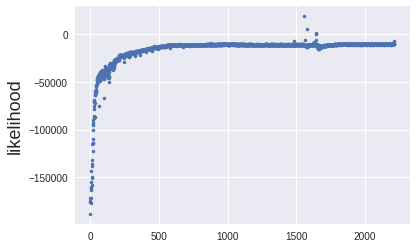

In [42]:
plt.plot(likelihoods,'.')
plt.ylabel('likelihood',fontsize=18);

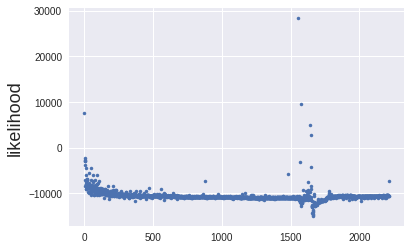

In [89]:
plt.plot(likelihoods,'.')
plt.ylabel('likelihood',fontsize=18);

(0.7148354436188902, 0.0)

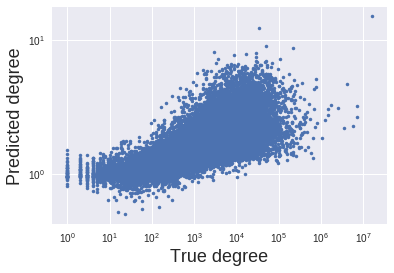

In [12]:
degree=np.squeeze(np.asarray(G.sum(axis=0)))
plt.loglog(degree,theta.sum(axis=1),'.');
plt.xlabel('True degree',fontsize=18);
plt.ylabel("Predicted degree",fontsize=18);
pearsonr(np.log(degree),np.log(theta.sum(axis=1)))

In [13]:
theta2=theta/theta.sum(axis=1).reshape(theta.shape[0],1)

In [198]:
(theta2<0.05).sum(axis=0) / theta2.shape[0]

array([0.78685201, 0.78391978, 0.78493339, 0.77515928, 0.78366638,
       0.77990153, 0.71709383, 0.77512308, 0.02342166, 0.7765711 ,
       0.78091515, 0.78337677, 0.78221836, 0.78406458, 0.78482479,
       0.78069794, 0.76882421, 0.78500579, 0.78725022, 0.78475239])

In [199]:
a=list(range(20))
a.remove(8)

In [200]:
theta3=theta2[:,a]
theta3=theta3**3
theta3=theta3/theta3.sum(axis=1).reshape(theta3.shape[0],1)

In [14]:
from sklearn.cluster import SpectralClustering

In [209]:
model=SpectralClustering(n_clusters=19,n_jobs=-1)

In [210]:
model.fit(theta3)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=19, n_init=10, n_jobs=-1, n_neighbors=10,
          random_state=None)

In [211]:
cluster=model.labels_.copy()

In [212]:
Counter(cluster)

Counter({0: 1303,
         1: 2622,
         2: 1316,
         3: 2444,
         4: 1351,
         5: 1320,
         6: 1307,
         7: 1318,
         8: 1325,
         9: 1293,
         10: 1303,
         11: 1321,
         12: 1333,
         13: 1598,
         14: 1306,
         15: 1269,
         16: 1283,
         17: 1354,
         18: 1258})

In [19]:
del model

In [20]:
random.sample(id2mesh[(cluster==3).nonzero()[0]].tolist(),10)

['Viscum',
 'Antigens, CD147',
 'Furans',
 'Clostridium tyrobutyricum',
 'Genome, Archaeal',
 'Zeranol',
 'Disintegrins',
 'Parasomnias',
 'Myxozoa',
 'Anorexia']

In [21]:
from sklearn.manifold import TSNE

In [224]:
tsne=TSNE(n_components=2)
centers=tsne.fit_transform(theta2[:,a].T)

In [238]:
tsne=MDS(n_components=2)
centers=tsne.fit_transform(theta2[:,a].T)

In [239]:
X=theta3.dot(centers)

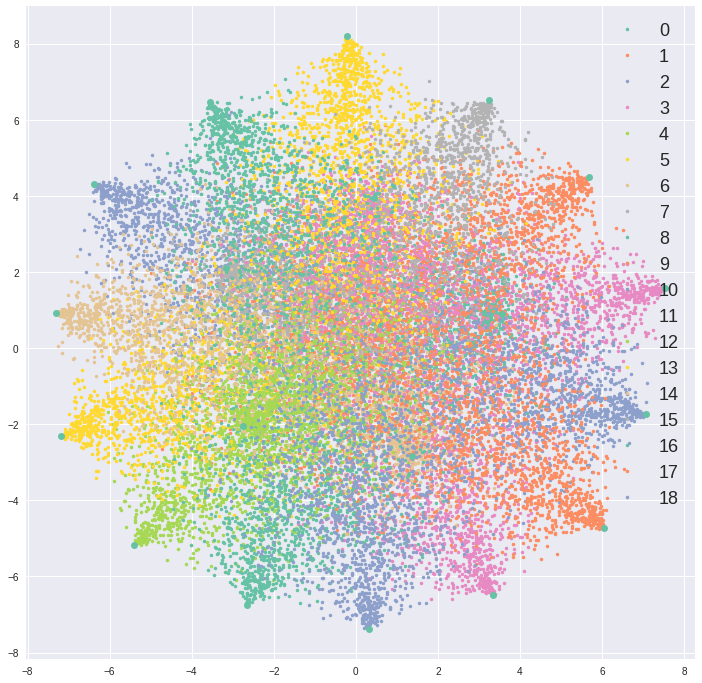

In [243]:
sns.set_palette('Set2',19)
fig,ax=plt.subplots(figsize=[12,12])
for i in range(19):
    plt.plot(X[cluster==i,0],X[cluster==i,1],'.',label=i);
plt.legend(fontsize=18);
plt.plot(centers[:,0],centers[:,1],'o');
# plt.ylim([-0.5,1.5]);

In [246]:
df=pd.read_csv('/home/bill10/Datasets/Medline/id_to_name.txt',sep='\t',header=None,names=['id','name'])

df['x']=X[:,0]

df['y']=X[:,1]

df['cluster']=cluster

df['degree']=G.sum(axis=0).A.ravel()

df.to_csv('../Results/mesh_terms2.tsv',sep='\t',index=False)